# Introduction

In this notebook we will be trying to predict gender from images. We will try making our own custom CNN and two variations of transfer learning to do this.  Therefore the goal of this part of the project is to both produce an accurate model and to train quickly and efficiently. We make the model faster by reducing the number of trainable parameters as much as we can. This is done by firstly resizing the images from (200, 200) to (64, 64) which retains almost all of the information but drastically reduces runtime. We will further construct our CNN model to minimize paramters by mapping the fully connected directly from the last convulation to the number of classes. This alieviates problems in a limited computational environment and agrees better with Occams razor framework with the premise that the simplest explanation is probably the best explanation. 

# Reading and Visualizing Data

In [3]:
import os
import tarfile

def removeFile(filename):
  prefix, ext = os.path.splitext(filename)
  newFilename = 'crop_part1_clean.tar.gz'
  original = tarfile.open(filename)
  modified = tarfile.open(newFilename, 'w')
  for info in original.getmembers():
    gender = info.name.replace('crop_part1/', '').split('_')[1]
    if gender != '0' and gender != '1':
      print(info.name)
      continue
    else:
      extracted = original.extractfile(info)
      modified.addfile(info, extracted)
  original.close()
  modified.close()

removeFile('/content/crop_part1.tar.gz')

crop_part1/61_3_20170109150557335.jpg.chip.jpg
crop_part1


In [4]:
from google.colab import drive
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import random 
import os, math
import pandas as pd 
from skimage import io 
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import save
from torch import load
import torchtext
import torch
import torchvision
# drive.mount('/content/drive')

In [5]:
import cv2 

class FaceDataset(Dataset):
    """Facial recognition dataset."""

    def __init__(self, root_dir, transform=None):
      self.info =  torchtext.utils.extract_archive(root_dir)
      self.root_dir = root_dir
      self.transform = transform

    def __len__(self):
      return len(self.info)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      file = self.info[idx]
      image = io.imread(file)
      image = cv2.resize(image, (64, 64))
      image = transforms.ToTensor()(image)
      # The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg
      age = file.replace('/content/crop_part1/', '').split('_')[0]
      gender = int(file.replace('/content/crop_part1/', '').split('_')[1])
      ethnicity = file.replace('/content/crop_part1/', '').split('_')[2]
      if gender != 0 and gender != 1:
        print(file)
        print(gender)

      if self.transform:
        image = self.transform(image)
      
      return (image, torch.tensor(gender))

In [6]:
path = '/content/crop_part1_clean.tar.gz'

data_transform = transforms.Compose([
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=.5),
      transforms.RandomPerspective(distortion_scale=0.2, p=.3, interpolation=torchvision.transforms.InterpolationMode.NEAREST, fill=0),
      transforms.RandomRotation(degrees = 30),
      # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

data = FaceDataset(path)
augmented_data = FaceDataset(path, transform=data_transform)
# increase the size of training data with image augmentation
combined_data = torch.utils.data.ConcatDataset([augmented_data, data])

In [7]:
# loader = DataLoader(combined_data, batch_size=len(combined_data), num_workers=2)
# sample = next(iter(loader))
# data_mean, data_std = sample[0].mean(), sample[0].std()

0 torch.Size([3, 64, 64])


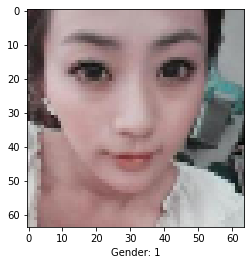

1 torch.Size([3, 64, 64])


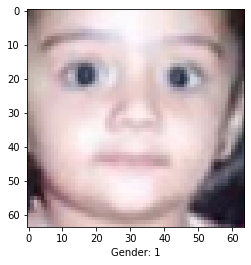

2 torch.Size([3, 64, 64])


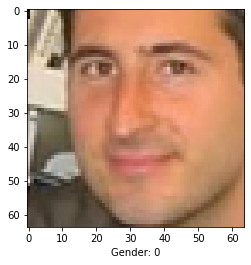

In [8]:
# non augmented images
for i in range(3):
    sample = data[i]

    print(i, sample[0].shape)
    plt.xlabel("Gender: {}".format(sample[1]))
    plt.imshow(sample[0].permute(1, 2, 0).numpy())
    plt.show()

0 torch.Size([3, 64, 64])


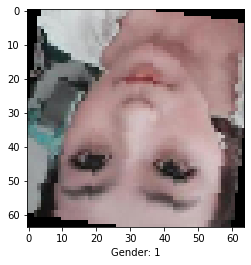

1 torch.Size([3, 64, 64])


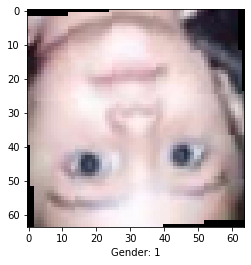

2 torch.Size([3, 64, 64])


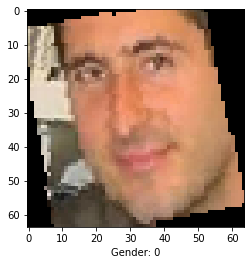

In [9]:
# augmented images
for i in range(3):
  sample = augmented_data[i]

  print(i, sample[0].shape)
  plt.xlabel("Gender: {}".format(sample[1]))
  plt.imshow(sample[0].permute(1, 2, 0).numpy())
  plt.show()

In [10]:
# split data into training/validation/test

# first split train/test with 80/20 split
train, test = torch.utils.data.random_split(combined_data, [15646, 3912])

# then split train into train/valid with a 75/25 split
train, valid = torch.utils.data.random_split(train, [11734, 3912])

# final percentages:
# train: .6, valid: .2, test: .2 

In [11]:
batch_size = 64
train_loader = DataLoader(train, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, num_workers=2, shuffle=True)

# Utility Functions



In [12]:
def init_weights(net):
    """
    Usage: net = Model()
           net.apply(init_weights)
    """
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

In [57]:
import torchvision.models as models
import torch.optim as optim


def train(args, save=False):
    device = torch.device("cuda")
    model = args.model.to(device)
    model.train()
    optimizer = optim.Adam(params=model.parameters(), lr=args.learning_rate, weight_decay=args.regularization, amsgrad=False)
    # optimizer = optim.SGD(params=model.parameters(), lr=args.learning_rate, weight_decay=args.regularization)
    criterion = torch.nn.CrossEntropyLoss()
    train_loader, valid_loader = args.train, args.valid 
    scheduler = optim.lr_scheduler.StepLR(optimizer, args.step, gamma=0.1, last_epoch=-1, verbose=True)

    if args.init_weight:
      model.apply(init_weights)

    train_loss_hist = []
    valid_loss_hist = []
    train_accuracy_hist = []
    valid_accuracy_hist = []

    for epoch in range(args.epochs):  # loop over the dataset multiple times
      model.train()
      train_loss = 0.0
      valid_loss = 0.0
      train_accuracy = 0.0
      valid_accuracy = 0.0
      total1, total2 = 0, 0

      for i, data in enumerate(train_loader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # zero the parameter gradients
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        
        # forward + backward + optimize
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_accuracy += (predicted == labels).float().sum() 
        total1 += inputs.size(0)


      for j, data in enumerate(valid_loader, 1):
        model.eval()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        valid_loss += (loss.item() * inputs.size(0))
        _, predicted = torch.max(outputs.data, 1)
        valid_accuracy += (predicted == labels).float().sum() 
        total2 += inputs.size(0)
      
      scheduler.step()
      train_loss = train_loss/total1
      valid_loss = valid_loss/total2
      train_accuracy = train_accuracy/total1
      valid_accuracy = valid_accuracy/total2
      
      train_loss_hist.append(train_loss)
      valid_loss_hist.append(valid_loss)
      train_accuracy_hist.append(train_accuracy)
      valid_accuracy_hist.append(valid_accuracy)
      print("Training Loss: {} Valid Loss: {} Training Accuracy: {} Valid Accuracy: {}"
      .format(train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    if save:
      torch.save(model, 'model')

    return (train_loss_hist, valid_loss_hist, train_accuracy_hist, valid_accuracy_hist)

In [22]:
def graph_train_valid(train_data, valid_data, title):
  epochs = len(train_data)
  plt.plot(range(epochs), train_data, label="training {}".format(title))
  plt.plot(range(epochs), valid_data, label = 'validation {}'.format(title))
  plt.title('model {}'.format(title))
  plt.xlabel("epochs")
  plt.ylabel(title)
  plt.legend()
  plt.show()

In [23]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

def final_score(model, device, test_loader):
  model = model.to(device)
  model.eval()
  preds = []
  true = []
  start =  time.time()

  for i, data in enumerate(test_loader):
    inputs, labels = data 
    inputs = inputs.to(device)
    size = inputs.size(0)
    pred = torch.argmax(model(inputs), dim = 1).tolist()
    pred = map(int, pred)
    preds.extend(list(pred))
    true.extend(labels.tolist())

  precision = precision_score(true, preds)
  recall = recall_score(true, preds)
  f1 = f1_score(true, preds)

  cm = confusion_matrix(true, preds)
  df_cm = pd.DataFrame(cm, range(2), range(2))
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
  plt.show()

  end = time.time()

  return precision, recall, f1, (end-start)

# Custom CNN and train 

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class GenderCNN1(torch.nn.Module):
    def __init__(self):
      super(GenderCNN1, self).__init__() 
      self.dropout = nn.Dropout(.25)
      self.pool = nn.MaxPool2d((2, 2), (2, 2))

      self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, bias=True)
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, bias=False)
      self.batch1 = nn.BatchNorm2d(64)
      self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, bias=True)
      self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, bias=False)
      self.batch2 = nn.BatchNorm2d(64)

      self.fc1 = nn.Linear(in_features=6400, out_features=2, bias=False)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.batch1(self.conv2(x))
      x = F.relu(x)
      x = self.dropout(self.pool(x))

      x = F.relu(self.conv3(x))
      x = self.batch2(self.conv4(x))
      x = F.relu(x)
      x = self.dropout(self.pool(x))

      x = torch.flatten(x, 1)
      x = self.fc1(x)

      return x
      

device = torch.device("cuda")
model = GenderCNN1()
summary(model.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 60, 60]           2,432
            Conv2d-2           [-1, 64, 56, 56]          51,200
       BatchNorm2d-3           [-1, 64, 56, 56]             128
         MaxPool2d-4           [-1, 64, 28, 28]               0
           Dropout-5           [-1, 64, 28, 28]               0
            Conv2d-6           [-1, 64, 24, 24]         102,464
            Conv2d-7           [-1, 64, 20, 20]         102,400
       BatchNorm2d-8           [-1, 64, 20, 20]             128
         MaxPool2d-9           [-1, 64, 10, 10]               0
          Dropout-10           [-1, 64, 10, 10]               0
           Linear-11                    [-1, 2]          12,800
Total params: 271,552
Trainable params: 271,552
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/

In [25]:
import torch.optim as optim
class Args(object):
    pass

args1 = Args();
args1.learning_rate = .005
args1.regularization = 5e-4

args1.model = GenderCNN1()
args1.train = train_loader
args1.valid = valid_loader 
args1.epochs = 15
args1.init_weight = True
args1.step = 5
train_loss1, valid_loss1, train_accuracy1, valid_accuracy1, = train(args1)

Adjusting learning rate of group 0 to 5.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 1.2955075505951388 Valid Loss: 0.6245402149505654 Training Accuracy: 0.6035452485084534 Valid Accuracy: 0.6661553978919983
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 0.6278028709936817 Valid Loss: 0.6015526981441521 Training Accuracy: 0.6627748608589172 Valid Accuracy: 0.6799590587615967
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 0.5682049148611423 Valid Loss: 0.5547134350901488 Training Accuracy: 0.703937292098999 Valid Accuracy: 0.7226482629776001
Adjusting learning rate of group 0 to 5.0000e-03.
Training Loss: 0.5483993557114323 Valid Loss: 0.5657494528893313 Training Accuracy: 0.7185103297233582 Valid Accuracy: 0.6950408816337585
Adjusting learning rate of group 0 to 5.0000e-04.
Training Loss: 0.5299685920892022 Valid Loss: 0.5395547509924766 Training Accuracy: 0.7295892238616943 Valid Accuracy: 0.7198363542556763
Adjusting l

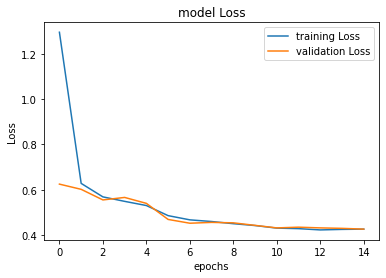

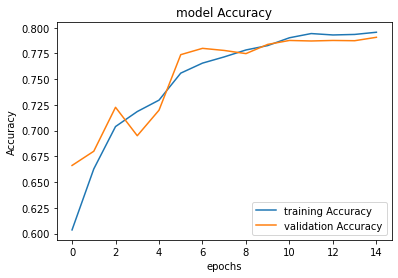

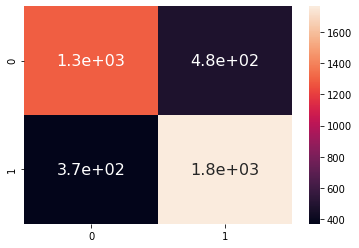

Test Precision: 0.7858414959928762 Test Recall: 0.8266978922716628 Test F1: 0.8057521113900936 Total Time: 5.486621141433716 seconds


In [26]:
graph_train_valid(train_loss1, valid_loss1, 'Loss')

graph_train_valid(train_accuracy1, valid_accuracy1, 'Accuracy')

precision1, recall1, f1_1, time1 = final_score(args1.model, device, test_loader)

print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision1, recall1, f1_1, time1))

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class GenderCNN2(torch.nn.Module):
    def __init__(self):
      super(GenderCNN2, self).__init__() 
      self.dropout = nn.Dropout(.25)
      self.pool1 = nn.MaxPool2d((2, 2), (2, 2))
      self.pool2 = nn.MaxPool2d((2, 2))

      self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=5, stride=1, bias=True)
      self.batch1 = nn.BatchNorm2d(96)

      self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, bias=False)
      self.batch2 = nn.BatchNorm2d(256)

      self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, bias=False)
      self.batch3 = nn.BatchNorm2d(384)

      self.conv4 = nn.Conv2d(in_channels=384, out_channels=512, kernel_size=3, stride=1, bias=False)
      self.batch4 = nn.BatchNorm2d(512)

      self.fc1 = nn.Linear(in_features=512, out_features=2, bias=False)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.dropout(self.pool1(self.batch1(x)))

      x = F.relu(self.conv2(x))
      x = self.dropout(self.pool2(self.batch2(x)))

      x = F.relu(self.conv3(x))
      x = self.dropout(self.pool2(self.batch3(x)))

      x = F.relu(self.conv4(x))
      x = self.dropout(self.pool2(self.batch4(x)))

      x = torch.flatten(x, 1)
      x = self.dropout(self.fc1(x))

      return x
      

device = torch.device("cuda")
model = GenderCNN2()
summary(model.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 60, 60]           7,296
       BatchNorm2d-2           [-1, 96, 60, 60]             192
         MaxPool2d-3           [-1, 96, 30, 30]               0
           Dropout-4           [-1, 96, 30, 30]               0
            Conv2d-5          [-1, 256, 26, 26]         614,400
       BatchNorm2d-6          [-1, 256, 26, 26]             512
         MaxPool2d-7          [-1, 256, 13, 13]               0
           Dropout-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 11, 11]         884,736
      BatchNorm2d-10          [-1, 384, 11, 11]             768
        MaxPool2d-11            [-1, 384, 5, 5]               0
          Dropout-12            [-1, 384, 5, 5]               0
           Conv2d-13            [-1, 512, 3, 3]       1,769,472
      BatchNorm2d-14            [-1, 51

In [28]:
import torch.optim as optim
class Args(object):
    pass

args2 = Args();
args2.learning_rate = .01
args2.regularization = 5e-4
args2.log_dir = 'logdir' 

args2.model = GenderCNN2()
args2.train = train_loader
args2.valid = valid_loader 
args2.epochs = 40 
args2.init_weight = True
args2.step = 10
train_loss2, valid_loss2, train_accuracy2, valid_accuracy2, = train(args2)

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.9336099234821241 Valid Loss: 0.6969449875423026 Training Accuracy: 0.5553945899009705 Valid Accuracy: 0.5736196041107178
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.7106366267557016 Valid Loss: 0.6508487757973388 Training Accuracy: 0.6067837476730347 Valid Accuracy: 0.5953476428985596
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.6538785848012871 Valid Loss: 0.5817906725504159 Training Accuracy: 0.6396796107292175 Valid Accuracy: 0.6840490698814392
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.6208122050374091 Valid Loss: 0.6066673572321855 Training Accuracy: 0.644792914390564 Valid Accuracy: 0.6477504968643188
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.5975813861699492 Valid Loss: 0.5730532885572905 Training Accuracy: 0.6641384363174438 Valid Accuracy: 0.6812372207641602
Adjusting l

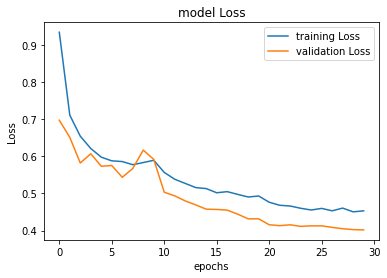

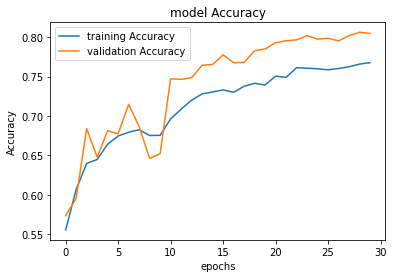

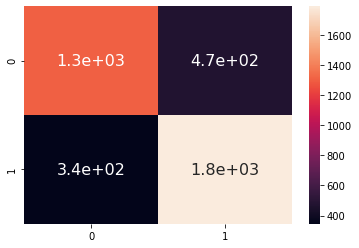

Test Precision: 0.7913351016799293 Test Recall: 0.8384074941451991 Test F1: 0.8141914942005913 Total Time: 5.3835999965667725 seconds


In [29]:
graph_train_valid(train_loss2, valid_loss2, 'Loss')

graph_train_valid(train_accuracy2, valid_accuracy2, 'Accuracy')

precision2, recall2, f1_2, time2 = final_score(args3.model, device, test_loader)

print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision2, recall2, f1_2, time2))

# Transfer Learning V1

  * replace last layer 
  * add dropout
  * high regularization
  * Train pretrained model for 10 epochs with all gradients
  * freeze everything that isn't the last layer
  * fine tune the last layer

In [58]:
class Args(object):
    pass

args3 = Args();
args3.learning_rate = 0.01
args3.regularization = .001

args3.train = train_loader
args3.valid = valid_loader 
args3.epochs = 10
args3.init_weight = False
args3.step = 4

In [60]:
# model = models.googlenet(pretrained=True)
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
for param in model.parameters():
    param.requires_grad = True

# add dropout to prevent overfitting 
model.fc = nn.Sequential(
     nn.Dropout(.25),
     nn.Linear(model.fc.in_features, 2)
)

args3.model = model
train(args3, save=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.8172883051449952 Valid Loss: 0.6839364798766217 Training Accuracy: 0.5455088019371033 Valid Accuracy: 0.5552147030830383
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.6344503070927365 Valid Loss: 0.6153806710657654 Training Accuracy: 0.630134642124176 Valid Accuracy: 0.6285787224769592
Adjusting learning rate of group 0 to 1.0000e-02.
Training Loss: 0.5890740998888089 Valid Loss: 0.5985788899209115 Training Accuracy: 0.682802140712738 Valid Accuracy: 0.6889058947563171
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.5843196023317178 Valid Loss: 0.6288872231978824 Training Accuracy: 0.6833986639976501 Valid Accuracy: 0.669222891330719
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.5371016202701181 Valid Loss: 0.5364790885482585 Training Accuracy: 0.7192773222923279 Valid Accuracy: 0.7254601120948792
Adjusting lea

([0.8172883051449952,
  0.6344503070927365,
  0.5890740998888089,
  0.5843196023317178,
  0.5371016202701181,
  0.5098280164895562,
  0.49822459772841293,
  0.4843349111980284,
  0.4549273708538402,
  0.44280340448237776],
 [0.6839364798766217,
  0.6153806710657654,
  0.5985788899209115,
  0.6288872231978824,
  0.5364790885482585,
  0.505509665529177,
  0.4965151222936946,
  0.5167368705287302,
  0.45104532653812496,
  0.44665181667283027],
 [tensor(0.5455, device='cuda:0'),
  tensor(0.6301, device='cuda:0'),
  tensor(0.6828, device='cuda:0'),
  tensor(0.6834, device='cuda:0'),
  tensor(0.7193, device='cuda:0'),
  tensor(0.7405, device='cuda:0'),
  tensor(0.7455, device='cuda:0'),
  tensor(0.7518, device='cuda:0'),
  tensor(0.7733, device='cuda:0'),
  tensor(0.7768, device='cuda:0')],
 [tensor(0.5552, device='cuda:0'),
  tensor(0.6286, device='cuda:0'),
  tensor(0.6889, device='cuda:0'),
  tensor(0.6692, device='cuda:0'),
  tensor(0.7255, device='cuda:0'),
  tensor(0.7405, device='cuda

In [61]:
# freeze everything except last few layer
i = 0
model = torch.load('model')
for param in model.parameters():
  if i >=155 and i <= 160:
    param.requires_grad = True
  else:
    param.requires_grad = False
  i += 1

args3.epochs = 20 
args3.learning_rate = 0.001
args3.regularization = .001
args3.step = 5
args3.model = model 

In [62]:
train_loss3, valid_loss3, train_accuracy3, valid_accuracy3, = train(args3)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.4300400034540533 Valid Loss: 0.44573634692252534 Training Accuracy: 0.7847281694412231 Valid Accuracy: 0.7768404483795166
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.4297891531818381 Valid Loss: 0.4460419432273428 Training Accuracy: 0.7811487913131714 Valid Accuracy: 0.7776073217391968
Adjusting learning rate of group 0 to 1.0000e-03.
Training Loss: 0.4271832008784037 Valid Loss: 0.4496183333830843 Training Accuracy: 0.784898579120636 Valid Accuracy: 0.7691717743873596
Adjusting learning rate of group 0 to 1.0000e-04.
Training Loss: 0.42555343796939893 Valid Loss: 0.4521833348006071 Training Accuracy: 0.7864326238632202 Valid Accuracy: 0.778374195098877
Adjusting learning rate of group 0 to 1.0000e-04.
Training Loss: 0.42601110576282925 Valid Loss: 0.4432087401061458 Training Accuracy: 0.7867735028266907 Valid Accuracy: 0.7819529175758362
Adjusting

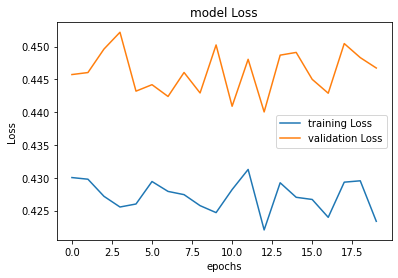

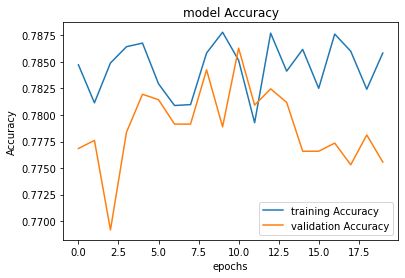

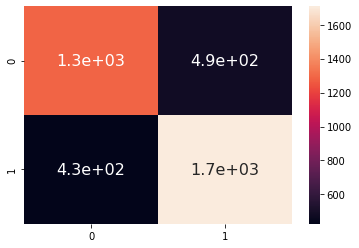

Test Precision: 0.778132118451025 Test Recall: 0.8 Test F1: 0.7889145496535797 Total Time: 5.733139753341675 seconds


In [63]:
graph_train_valid(train_loss3, valid_loss3, 'Loss')

graph_train_valid(train_accuracy3, valid_accuracy3, 'Accuracy')

precision3, recall3, f1_3, time3 = final_score(args3.model, device, test_loader)

print("Test Precision: {} Test Recall: {} Test F1: {} Total Time: {} seconds".format(precision3, recall3, f1_3, time3))

# Transfer Learning V2

  * Use pretrained-CNN as a feature extractor
  * Take output as last layer as input to new model
  * Convert everything to Apache Spark so that we can actually compute it in reasonable time
  * Use train/validation for hyperparameter tuning for Random Forest
  * Measure final model accuracy for Random Forest using test data


In [67]:
class Args(object):
    pass
device = torch.device('cuda')
args4 = Args()
model = models.googlenet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

args4.model = model
# summary(model.to(device), (3, 64, 64))

In [68]:
def transfer(model, device, batch_size, num_features, loader):
  model = model.to(device)
  model.eval()
  x = pd.DataFrame(0, index=range(len(loader) * batch_size), columns=range(num_features))
  y = pd.DataFrame(0, index=range(len(loader) * batch_size), columns=range(1))

  for i, data in enumerate(loader, 0):
      inputs, labels = data
      inputs = inputs.to(device)
      size = inputs.size(0)
      labels = labels.to(device).cpu().detach().numpy().reshape(size, 1)
      outputs = model(inputs).cpu().detach().numpy()
      x[i * size: (i+1) * size]  = outputs
      y[i * size: (i+1) * size]  = labels

  return (x, y)

In [69]:
num_features = 1000
x_train, y_train = transfer(args4.model, device, 64, num_features, train_loader)
x_valid, y_valid = transfer(args4.model, device, 64, num_features, valid_loader)
x_test, y_test = transfer(args4.model, device, 64, num_features, test_loader)
train = pd.concat([x_train, y_train], axis=1)
valid = pd.concat([x_valid, y_valid], axis=1)
test = pd.concat([x_test, y_test], axis=1)

In [70]:
cols = ['feature'+str(i) for i in range(1000)]
cols.append('gender')

train.set_axis(cols, axis=1, inplace=True)
valid.set_axis(cols, axis=1, inplace=True)
test.set_axis(cols, axis=1, inplace=True)

In [71]:
train.to_csv('train')
valid.to_csv('valid')
test.to_csv('test')

In [72]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 68kB/s 
     |████████████████████████████████| 204kB 55.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=16b9ddbd06cd83259926ed1f02801c974a999272295060914464ae64fd19c284
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [73]:
from pyspark.sql import SparkSession
import pyspark
import pandas as pd

spark = SparkSession.builder.appName('random forest').getOrCreate()

train_sdf = spark.read.csv('train', inferSchema=True, header=True)
test_sdf = spark.read.csv('test', inferSchema=True, header=True)

In [101]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

cols = train_sdf.columns

assembler = VectorAssembler(inputCols=cols[:-1], outputCol='features')
train_sdf = assembler.transform(train_sdf)


In [102]:
cols = test_sdf.columns

assembler = VectorAssembler(inputCols=cols[:-1], outputCol='features')
test_sdf = assembler.transform(test_sdf)


In [76]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="gender", featuresCol="features")
rf = rf.fit(train_sdf)

In [77]:
train_predictions = rf.transform(train_sdf)
test_predictions = rf.transform(test_sdf)

In [97]:
from pyspark.sql.functions import col

list1 = train_predictions.select(col("prediction")).collect()
train_pred = [int(row.prediction) for row in list1]

list2 = test_predictions.select(col("prediction")).collect()
test_pred = [int(row.prediction) for row in list2]

list3 = train_predictions.select(col("gender")).collect()
train_label = [int(row.gender) for row in list3]

list4 = test_predictions.select(col("gender")).collect()
test_label = [int(row.gender) for row in list4]

In [98]:
precision_train = precision_score(train_pred, train_label)
recall_train = recall_score(train_pred, train_label)
f1_train = f1_score(train_pred, train_label)

precision_test = precision_score(test_pred, test_label)
recall_test = recall_score(test_pred, test_label)
f1_test = f1_score(test_pred, test_label)

print("Train Precision: {} Train Recall: {} Train F1: {} ".format(precision_train, recall_train, f1_train))
print("TestPrecision: {} Test Recall: {} Test F1: {} ".format(precision_test, recall_test, f1_test))

Train Precision: 0.7544264819091608 Train Recall: 0.7433252427184466 Train F1: 0.7488347214793306 
TestPrecision: 0.7342723004694836 Test Recall: 0.7148080438756855 Test F1: 0.7244094488188976 


#Comparing Models

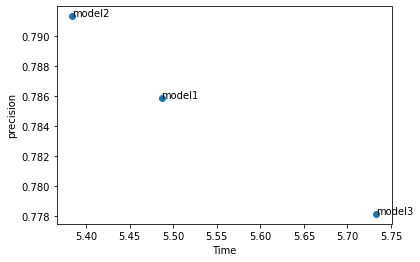

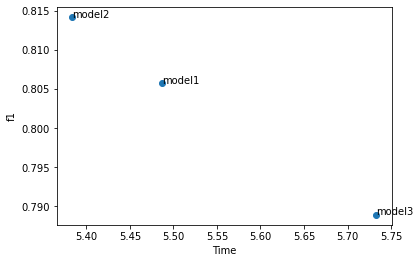

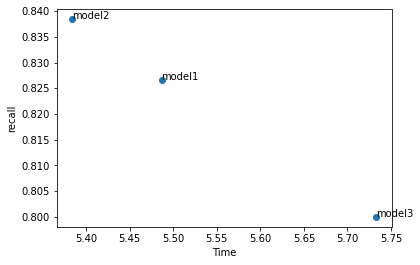

In [100]:
def graph_performance_vs_time(performance, time, names, title):
  plt.scatter(x=time, y=performance)
  for i, label in enumerate(names):
    plt.annotate(label, (time[i], performance[i]))
  plt.xlabel('Time')
  plt.ylabel(title)
  plt.show()

tot_precision = [precision1, precision2, precision3]
tot_f1 = [f1_1, f1_2, f1_3]
tot_recall = [recall1, recall2, recall3]
tot_time = [time1, time2, time3]
names = ['model1', 'model2', 'model3']

graph_performance_vs_time(tot_precision, tot_time, names, 'precision')
graph_performance_vs_time(tot_f1, tot_time, names, 'f1')
graph_performance_vs_time(tot_recall, tot_time, names, 'recall')